# Importing libraries 

In [1]:
from cashe import get_train_test_split, get_training_inputs, drop_nomodel_columns
from src.model_app import ModelApplication, ModelApplicationDeployment
from src.utilities_rejection import RejectionReasonLabeling
from src.data_local import MergedDataPreprocessing
from src.model_train import ModelTrainer
import pandas as pd
import numpy as np
import shap

# Reading Train and Test data

In [2]:
df_train, df_test = get_train_test_split('data/HJH/12-06-2024')
df_train = df_train[df_train['OUTCOME'] !='APPROVED']
df_test = df_test[df_test['OUTCOME'] !='APPROVED']

train_rej = RejectionReasonLabeling(df_train)
train_rej.recoginze_label()
train_rej = RejectionReasonLabeling(df_test)
train_rej.recoginze_label()

In [3]:
df_train["NPHIES_CODE"].value_counts()

NPHIES_CODE
MN-1-1     17007
CV-1-1     12461
SE-1-6     10171
BE-1-7      7636
BE-1-3      4125
BE-1-6      4068
BE-1-1      3114
BE-1-4      2595
SE-1-8      1297
CV-1-3      1136
AD-2-4      1130
SE-1-9       927
AD-2-5       669
CV-1-4       642
BE-1-5       366
CV-1-2       363
CV-3-2       354
AD-2-6       342
AD-3-2       329
SE-1-2       236
CV-3-5       235
AD-1-6       219
CV-1-8       192
AD-3-3       112
BE-1-10       73
CV-2-1        67
AD-1-3        59
AD-1-7        57
CV-3-1        29
AD-1-4        25
CV-1-9        19
AD-3-5        17
AD-3-7        16
BE-1-2        11
CV-1-10        5
MN-1-2         4
SE-1-5         1
AD-3-8         1
SE-1-7         1
Name: count, dtype: int64

In [4]:
df_train.head()

,CREATED_BY_USER,CREATION_DATE,VISIT_ID,NET_WITH_VAT,SERVICE_DESCRIPTION,QTY,LINE_CLAIMED_AMOUNT,LINE_CLAIMED_AMOUNT_SAR,CO_PAY,CO_INSURANCE,...,PATIENT_IDENTITY_TYPE,BILLABLE_PERIOD_START,BILLABLE_PERIOD_END,BATCH_PERIOD_START,BATCH_PERIOD_END,Episode_Key,ICD10,Diagnosis_Key,PatientAgeRange,NPHIES_CODE
398360,9643,2024-01-01 12:38:12,194136,138.00,Consultation,1.0,120.00,120.00,0.00,120.00,...,H,2023-12-06,2023-12-20,2023-12-01,2023-12-10,1_1343530-4,12,1_1111225570,1,CV-1-1
398361,9643,2024-01-01 12:38:36,194137,12.98,Unlisted Code,1.0,16.13,16.13,0.00,16.13,...,H,2023-12-03,2023-12-04,2023-12-01,2023-12-10,1_1343731-2,15,1_1111228814,5,CV-1-1
398365,9643,2024-01-01 12:38:36,194137,1.56,SPASMOPAN 20MG AMP.,1.0,1.69,1.69,0.31,1.38,...,H,2023-12-03,2023-12-04,2023-12-01,2023-12-10,1_1343731-2,15,1_1111228814,5,CV-1-1
398364,9643,2024-01-01 12:38:36,194137,1427.30,Therapeutic ultrasound,1.0,1791.68,1791.68,100.00,1691.68,...,H,2023-12-03,2023-12-04,2023-12-01,2023-12-10,1_1343731-2,15,1_1111228814,5,CV-1-1
398363,9643,2024-01-01 12:38:36,194137,4.37,OLFEN-75,1.0,4.71,4.71,0.87,3.84,...,H,2023-12-03,2023-12-04,2023-12-01,2023-12-10,1_1343731-2,15,1_1111228814,5,CV-1-1


# Double checking the VISIT_NO

In [5]:
subject_claims = df_train.groupby(["VISIT_NO","SERVICE_DESCRIPTION"])["OUTCOME"].nunique().reset_index()

subject_claims.iloc[subject_claims.OUTCOME.argmax()]

VISIT_NO                   1011143-2
SERVICE_DESCRIPTION    Albumin Assay
OUTCOME                            2
Name: 261, dtype: object

In [6]:
df_train.query("VISIT_NO == '1011143-2'")

,CREATED_BY_USER,CREATION_DATE,VISIT_ID,NET_WITH_VAT,SERVICE_DESCRIPTION,QTY,LINE_CLAIMED_AMOUNT,LINE_CLAIMED_AMOUNT_SAR,CO_PAY,CO_INSURANCE,...,PATIENT_IDENTITY_TYPE,BILLABLE_PERIOD_START,BILLABLE_PERIOD_END,BATCH_PERIOD_START,BATCH_PERIOD_END,Episode_Key,ICD10,Diagnosis_Key,PatientAgeRange,NPHIES_CODE
51354,9521,2024-05-04 15:02:24,241478,89.07,"Liver enzyme (SGPT), Level",1.0,110.64,110.64,0.00,110.64,...,IQ,2024-04-17,2024-05-01,2024-04-11,2024-04-30,1_1011143-2,3,1_111222347,5,CV-1-1
51358,9521,2024-05-04 15:02:24,241478,70.31,R . Factor,1.0,87.34,87.34,0.00,87.34,...,IQ,2024-04-17,2024-05-01,2024-04-11,2024-04-30,1_1011143-2,3,1_111222347,5,CV-1-1
51353,9521,2024-05-04 15:02:24,241478,107.80,Albumin Assay,1.0,133.92,133.92,0.00,133.92,...,IQ,2024-04-17,2024-05-01,2024-04-11,2024-04-30,1_1011143-2,3,1_111222347,5,CV-1-1
51352,9521,2024-05-04 15:02:24,241478,134.40,Consultant Consultation,1.0,120.00,120.00,24.00,96.00,...,IQ,2024-04-17,2024-05-01,2024-04-11,2024-04-30,1_1011143-2,3,1_111222347,5,CV-1-1
51351,9521,2024-05-04 15:02:24,241478,82.17,Creatinine Assay,1.0,104.80,104.80,14.67,90.13,...,IQ,2024-04-17,2024-05-01,2024-04-11,2024-04-30,1_1011143-2,3,1_111222347,5,CV-1-1
47868,9521,2024-05-04 15:02:24,241478,131.26,Automated complete Blood cell and differentia...,1.0,163.06,163.06,0.00,163.06,...,IQ,2024-04-17,2024-05-01,2024-04-11,2024-04-30,1_1011143-2,3,1_111222347,5,CV-1-1
51356,9521,2024-05-04 15:02:24,241478,135.93,Bilirubin Total,1.0,168.86,168.86,0.00,168.86,...,IQ,2024-04-17,2024-05-01,2024-04-11,2024-04-30,1_1011143-2,3,1_111222347,5,CV-1-1
51355,9521,2024-05-04 15:02:24,241478,168.75,G.G.T,1.0,209.63,209.63,0.00,209.63,...,IQ,2024-04-17,2024-05-01,2024-04-11,2024-04-30,1_1011143-2,3,1_111222347,5,CV-1-1
51357,9521,2024-05-04 15:02:24,241478,99.52,B.T (Bleeding time ),1.0,123.63,123.63,0.00,123.63,...,IQ,2024-04-17,2024-05-01,2024-04-11,2024-04-30,1_1011143-2,3,1_111222347,5,CV-1-1
51350,9521,2024-05-04 15:02:24,241478,674.49,CT soft tissue neck w IV contrast medium,1.0,591.25,591.25,36.33,554.92,...,IQ,2024-04-17,2024-05-01,2024-04-11,2024-04-30,1_1011143-2,3,1_111222347,5,CV-1-1


In [7]:
# Check for duplicated claims on VISIT_NO LEVEL
cols = ['VISIT_NO','NET_WITH_VAT', 'SERVICE_DESCRIPTION', 'QTY', 'LINE_CLAIMED_AMOUNT_SAR', 'LINE_ITEM_DISCOUNT', 'NET_VAT_AMOUNT', 'PATIENT_VAT_AMOUNT', 'VAT_PERCENTAGE', 'TREATMENT_TYPE_INDICATOR', 'SERVICE_TYPE', 'DURATION', 'QTY_STOCKED_UOM', 'OASIS_IOS_DESCRIPTION', 'UNIT_PRICE_STOCKED_UOM', 'UNIT_PRICE_NET', 'DISCOUNT_PERCENTAGE', 'EMERGENCY_INDICATOR', 'PROVIDER_DEPARTMENT_CODE', 'PROVIDER_DEPARTMENT', 'DOCTOR_SPECIALTY_CODE', 'DOCTOR_CODE', 'PATIENT_AGE', 'UNIT_OF_AGE', 'PATIENT_NATIONALITY', 'PATIENT_MARITAL_STATUS', 'PATIENT_GENDER', 'CLAIM_TYPE', 'TOTAL_CLAIMED_AMOUNT_SAR', 'TOTAL_DISCOUNT', 'TOTAL_DEDUCTIBLE', 'TOTAL_PATIENT_VATAMOUNT', 'DEPARTMENT_TYPE', 'TREATMENT_TYPE', 'PURCHASER_CODE', 'NEW_BORN', 'ICD10']

df_train[df_train.duplicated(cols)].groupby(['VISIT_NO','SERVICE_DESCRIPTION'])['NPHIES_CODE'].nunique().reset_index().iloc[59]

VISIT_NO                1183335-10
SERVICE_DESCRIPTION    Medical bag
NPHIES_CODE                      3
Name: 59, dtype: object

In [8]:
df_train.query('VISIT_NO == "1183335-10" and SERVICE_DESCRIPTION == "Medical bag"')


,CREATED_BY_USER,CREATION_DATE,VISIT_ID,NET_WITH_VAT,SERVICE_DESCRIPTION,QTY,LINE_CLAIMED_AMOUNT,LINE_CLAIMED_AMOUNT_SAR,CO_PAY,CO_INSURANCE,...,PATIENT_IDENTITY_TYPE,BILLABLE_PERIOD_START,BILLABLE_PERIOD_END,BATCH_PERIOD_START,BATCH_PERIOD_END,Episode_Key,ICD10,Diagnosis_Key,PatientAgeRange,NPHIES_CODE
383514,10269,2024-04-24 12:39:16,237461,2.61,Medical bag,2.0,2.85,2.85,0.0,2.85,...,IQ,2024-03-31 05:27:26,2024-04-03 14:50:45,2024-04-01,2024-04-10,1_1183335-10,10,1_111225233,9,BE-1-3
382131,10269,2024-04-24 12:39:16,237461,7.60,Medical bag,1.0,8.00,8.00,0.0,8.00,...,IQ,2024-03-31 05:27:26,2024-04-03 14:50:45,2024-04-01,2024-04-10,1_1183335-10,10,1_111225233,9,SE-1-2
117628,10335,2024-05-09 13:24:39,245751,7.60,Medical bag,1.0,8.00,8.00,0.0,8.00,...,IQ,2024-03-31 05:27:26,2024-04-03 14:50:45,2024-04-01,2024-04-10,1_1183335-10,10,1_111225233,9,CV-1-1
118025,10335,2024-05-09 13:24:39,245751,2.61,Medical bag,2.0,2.85,2.85,0.0,2.85,...,IQ,2024-03-31 05:27:26,2024-04-03 14:50:45,2024-04-01,2024-04-10,1_1183335-10,10,1_111225233,9,CV-1-1
128637,10335,2024-05-11 11:23:04,245752,7.60,Medical bag,1.0,8.00,8.00,0.0,8.00,...,IQ,2024-03-31 05:27:26,2024-04-03 14:50:45,2024-04-01,2024-04-10,1_1183335-10,10,1_111225233,9,CV-1-1
128638,10335,2024-05-11 11:23:04,245752,2.61,Medical bag,2.0,2.85,2.85,0.0,2.85,...,IQ,2024-03-31 05:27:26,2024-04-03 14:50:45,2024-04-01,2024-04-10,1_1183335-10,10,1_111225233,9,CV-1-1
112637,10335,2024-05-18 13:22:20,245795,2.61,Medical bag,2.0,2.85,2.85,0.0,2.85,...,IQ,2024-03-31 05:27:26,2024-04-03 14:50:45,2024-04-01,2024-04-10,1_1183335-10,10,1_111225233,9,CV-1-1
112635,10335,2024-05-18 13:22:20,245795,7.60,Medical bag,1.0,8.00,8.00,0.0,8.00,...,IQ,2024-03-31 05:27:26,2024-04-03 14:50:45,2024-04-01,2024-04-10,1_1183335-10,10,1_111225233,9,CV-1-1
128406,10335,2024-05-20 13:09:59,245817,7.60,Medical bag,1.0,8.00,8.00,0.0,8.00,...,IQ,2024-03-31 05:27:26,2024-04-03 14:50:45,2024-04-01,2024-04-10,1_1183335-10,10,1_111225233,9,SE-1-2
128408,10335,2024-05-20 13:09:59,245817,2.61,Medical bag,2.0,2.85,2.85,0.0,2.85,...,IQ,2024-03-31 05:27:26,2024-04-03 14:50:45,2024-04-01,2024-04-10,1_1183335-10,10,1_111225233,9,BE-1-3


In [9]:
df_train.query("VISIT_NO == '1065539-8'").groupby('SERVICE_DESCRIPTION')['OUTCOME'].value_counts()


SERVICE_DESCRIPTION             OUTCOME 
Percutaneous lumbar discectomy  REJECTED    3
Name: count, dtype: int64

# Visualising RES_CLAIM_ID vs PURCHASER_CODE

In [10]:
df_train[['RES_CLAIM_ID','PURCHASER_CODE']]

,RES_CLAIM_ID,PURCHASER_CODE
398360,http://Medgulf.com.sa/ClaimResponse/1431178,2134
398361,http://Medgulf.com.sa/ClaimResponse/1431179,2134
398365,http://Medgulf.com.sa/ClaimResponse/1431179,2134
398364,http://Medgulf.com.sa/ClaimResponse/1431179,2134
398363,http://Medgulf.com.sa/ClaimResponse/1431179,2134
...,...,...
164555,http://Medgulf.com.sa/ClaimResponse/1847998,2134
164557,http://Medgulf.com.sa/ClaimResponse/1847998,2134
164569,http://Medgulf.com.sa/ClaimResponse/1847998,2134
164566,http://Medgulf.com.sa/ClaimResponse/1847998,2134


# Identifying NPHIES LABEL MN-1-1 as code of intrest

In [11]:
error_value = 'MN-1-1'

df_train['NPHIES_LABEL'] = np.where(df_train['NPHIES_CODE'] == error_value, 1, 0)
df_test['NPHIES_LABEL']  = np.where( df_test['NPHIES_CODE']  == error_value, 1, 0)

In [12]:
df_train["NPHIES_LABEL"].value_counts()

NPHIES_LABEL
0    62682
1    17007
Name: count, dtype: int64

In [13]:
df_train.PURCHASER_CODE.nunique()

32

# get training columns

In [14]:
X_train, y_train, X_test, y_test = get_training_inputs(df_train, df_test)

In [15]:
X_train.columns

Index(['CREATED_BY_USER', 'CREATION_DATE', 'VISIT_ID', 'NET_WITH_VAT',
       'SERVICE_DESCRIPTION', 'QTY', 'LINE_CLAIMED_AMOUNT',
       'LINE_CLAIMED_AMOUNT_SAR', 'CO_PAY', 'CO_INSURANCE',
       'LINE_ITEM_DISCOUNT', 'NET_AMOUNT', 'NET_VAT_AMOUNT',
       'PATIENT_VAT_AMOUNT', 'VAT_PERCENTAGE', 'TREATMENT_TYPE_INDICATOR',
       'SERVICE_TYPE', 'DURATION', 'QTY_STOCKED_UOM', 'UNIT_PRICE',
       'OASIS_IOS_DESCRIPTION', 'SEQUENCE_NO', 'UNIT_PRICE_STOCKED_UOM',
       'UNIT_PRICE_NET', 'DISCOUNT_PERCENTAGE', 'NOTES', 'APPROVED_QUNATITY',
       'REQUEST_DATE', 'VISIT_NO', 'VISIT_DATE', 'EMERGENCY_INDICATOR',
       'PROVIDER_DEPARTMENT_CODE', 'PROVIDER_DEPARTMENT',
       'DOCTOR_SPECIALTY_CODE', 'DOCTOR_CODE', 'PATIENT_NO', 'EPISODE_NO',
       'PATIENT_ID', 'MEMBERSHIP_NO', 'PATIENT_ID_TYPE',
       'PATIENT_NATIONAL_IQAMA_ID', 'PATIENT_DOB', 'PATIENT_AGE',
       'UNIT_OF_AGE', 'PATIENT_NATIONALITY', 'PATIENT_MARITAL_STATUS',
       'PATIENT_GENDER', 'PATIENT_MOBILE_NO', 'PATIENT_

In [16]:
X_train = drop_nomodel_columns(X_train)
X_test = drop_nomodel_columns(X_test)
X_train.columns

Index(['NET_WITH_VAT', 'SERVICE_DESCRIPTION', 'QTY', 'LINE_CLAIMED_AMOUNT_SAR',
       'LINE_ITEM_DISCOUNT', 'NET_VAT_AMOUNT', 'PATIENT_VAT_AMOUNT',
       'VAT_PERCENTAGE', 'TREATMENT_TYPE_INDICATOR', 'SERVICE_TYPE',
       'DURATION', 'QTY_STOCKED_UOM', 'OASIS_IOS_DESCRIPTION',
       'UNIT_PRICE_STOCKED_UOM', 'UNIT_PRICE_NET', 'DISCOUNT_PERCENTAGE',
       'EMERGENCY_INDICATOR', 'PROVIDER_DEPARTMENT_CODE',
       'PROVIDER_DEPARTMENT', 'DOCTOR_SPECIALTY_CODE', 'DOCTOR_CODE',
       'PATIENT_AGE', 'UNIT_OF_AGE', 'PATIENT_NATIONALITY',
       'PATIENT_MARITAL_STATUS', 'PATIENT_GENDER', 'CLAIM_TYPE',
       'TOTAL_CLAIMED_AMOUNT_SAR', 'TOTAL_DISCOUNT', 'TOTAL_DEDUCTIBLE',
       'TOTAL_PATIENT_VATAMOUNT', 'DEPARTMENT_TYPE', 'TREATMENT_TYPE',
       'PURCHASER_CODE', 'NEW_BORN', 'ICD10', 'PatientAgeRange',
       'NPHIES_CODE'],
      dtype='object')

In [17]:
# # Drop all columns that include 'CODE' in their name
# X_train.drop(columns=[col for col in X_train.columns if 'CODE' in col],inplace=True); X_test.drop(columns=[col for col in X_test.columns if 'CODE' in col],inplace=True)

In [18]:
X_train.drop(columns=['NPHIES_CODE'],inplace=True); X_test.drop(columns=['NPHIES_CODE'],inplace=True)

In [19]:
# X_train.NPHIES_CODE

# Checking the target label distribution  for train and test sets

In [20]:
y_train.NPHIES_LABEL.value_counts(normalize=True)

NPHIES_LABEL
0    0.786583
1    0.213417
Name: proportion, dtype: float64

In [21]:
y_test.NPHIES_LABEL.value_counts(normalize=True)

NPHIES_LABEL
0    0.78588
1    0.21412
Name: proportion, dtype: float64

# Preprocessing and encoding features

In [22]:
preprocessing_train = MergedDataPreprocessing(X_train)
X_train_prep = preprocessing_train.columns_prep(service_encoding=False)

preprocessing_test = MergedDataPreprocessing(X_test)
X_test_prep = preprocessing_test.columns_prep(service_encoding=False)

X_train_encoded = preprocessing_train.column_embedding(X_train_prep)
X_test_encoded = preprocessing_train.column_embedding(X_test_prep)

X_train_encoded.fillna(0,inplace=True)
X_test_encoded.fillna(0,inplace=True)

C:\AI_Projects\Claims_Rejection_2024\Claims_Rejection\src\data_local.py:269: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  self.df['PatientAgeRange'] = self.df.PatientAgeRange.replace(age_encoding)
C:\AI_Projects\Claims_Rejection_2024\Claims_Rejection\src\data_local.py:269: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  self.df['PatientAgeRange'] = self.df.PatientAgeRange.replace(age_encoding)


In [23]:
X_test_encoded['ICD10']

397468     8
397260    11
397261    11
397310    13
397266    13
          ..
159314    22
178827    15
178825    15
178824    15
178826    15
Name: ICD10, Length: 19816, dtype: int64

In [24]:
X_test_encoded.columns

Index(['NET_WITH_VAT', 'QTY', 'LINE_CLAIMED_AMOUNT_SAR', 'LINE_ITEM_DISCOUNT',
       'NET_VAT_AMOUNT', 'PATIENT_VAT_AMOUNT', 'VAT_PERCENTAGE',
       'TREATMENT_TYPE_INDICATOR', 'DURATION', 'QTY_STOCKED_UOM',
       'UNIT_PRICE_STOCKED_UOM', 'UNIT_PRICE_NET', 'DISCOUNT_PERCENTAGE',
       'EMERGENCY_INDICATOR', 'PROVIDER_DEPARTMENT_CODE',
       'DOCTOR_SPECIALTY_CODE', 'DOCTOR_CODE', 'PATIENT_AGE', 'UNIT_OF_AGE',
       'PATIENT_NATIONALITY', 'PATIENT_MARITAL_STATUS', 'PATIENT_GENDER',
       'CLAIM_TYPE', 'TOTAL_CLAIMED_AMOUNT_SAR', 'TOTAL_DISCOUNT',
       'TOTAL_DEDUCTIBLE', 'TOTAL_PATIENT_VATAMOUNT', 'DEPARTMENT_TYPE',
       'TREATMENT_TYPE', 'PURCHASER_CODE', 'NEW_BORN', 'ICD10',
       'PatientAgeRange', 'CombinedText1', 'CombinedText2', 'CombinedText3',
       'CombinedText4', 'CombinedText5', 'CombinedText6', 'CombinedText7',
       'CombinedText8', 'CombinedText9', 'CombinedText10', 'CombinedText11',
       'CombinedText12', 'CombinedText13', 'CombinedText14', 'CombinedText

# Fitting Models

In [25]:
model_runner = ModelTrainer(X_train=X_train_encoded,y_train=y_train['NPHIES_LABEL'],
                                X_test=X_test_encoded,y_test=y_test['NPHIES_LABEL'],)

model_runner.train_models()

[LightGBM] [Info] Number of positive: 17007, number of negative: 62682
[LightGBM] [Info] Total Bins 5706
[LightGBM] [Info] Number of data points in the train set: 79689, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.213417 -> initscore=-1.304449
[LightGBM] [Info] Start training from score -1.304449


E:\SC\testing\Claims_Rejection\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(




LightGBM, Decision Tree, SGD and Neural Network are trained on dataset.


In [27]:
model_runner.evaluate_models()

{'Decision Tree': {'Accuracy': 0.87,
  'Precision': 0.7,
  'Recall': 0.72,
  'F1 Score': 0.71},
 'LightGBM': {'Accuracy': 0.89,
  'Precision': 0.84,
  'Recall': 0.61,
  'F1 Score': 0.7},
 'SGD Classifier': {'Accuracy': 0.22,
  'Precision': 0.22,
  'Recall': 1.0,
  'F1 Score': 0.35},
 'XGBoost': {'Accuracy': 0.9,
  'Precision': 0.85,
  'Recall': 0.67,
  'F1 Score': 0.75},
 'Neural Network': {'Accuracy': 0.81,
  'Precision': 0.57,
  'Recall': 0.41,
  'F1 Score': 0.48}}

In [36]:
top_model_features = model_runner.get_xgboost_feature_importance()

features_df = pd.DataFrame({"Column_name":X_test_encoded.columns,"Feature_importance":top_model_features}).sort_values(
    by=['Feature_importance'],ascending=False)
features_df

,Column_name,Feature_importance
6,VAT_PERCENTAGE,0.120353
29,PURCHASER_CODE,0.079196
27,DEPARTMENT_TYPE,0.057437
28,TREATMENT_TYPE,0.050552
14,PROVIDER_DEPARTMENT_CODE,0.042790
12,DISCOUNT_PERCENTAGE,0.037234
42,CombinedText10,0.031328
10,UNIT_PRICE_STOCKED_UOM,0.029768
37,CombinedText5,0.026356
35,CombinedText3,0.024782


In [37]:
xgb_model = model_runner.xgb_model

In [ ]:
model_runner.l

In [38]:
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test_encoded)

In [39]:
X_test_encoded.columns

Index(['NET_WITH_VAT', 'QTY', 'LINE_CLAIMED_AMOUNT_SAR', 'LINE_ITEM_DISCOUNT',
       'NET_VAT_AMOUNT', 'PATIENT_VAT_AMOUNT', 'VAT_PERCENTAGE',
       'TREATMENT_TYPE_INDICATOR', 'DURATION', 'QTY_STOCKED_UOM',
       'UNIT_PRICE_STOCKED_UOM', 'UNIT_PRICE_NET', 'DISCOUNT_PERCENTAGE',
       'EMERGENCY_INDICATOR', 'PROVIDER_DEPARTMENT_CODE',
       'DOCTOR_SPECIALTY_CODE', 'DOCTOR_CODE', 'PATIENT_AGE', 'UNIT_OF_AGE',
       'PATIENT_NATIONALITY', 'PATIENT_MARITAL_STATUS', 'PATIENT_GENDER',
       'CLAIM_TYPE', 'TOTAL_CLAIMED_AMOUNT_SAR', 'TOTAL_DISCOUNT',
       'TOTAL_DEDUCTIBLE', 'TOTAL_PATIENT_VATAMOUNT', 'DEPARTMENT_TYPE',
       'TREATMENT_TYPE', 'PURCHASER_CODE', 'NEW_BORN', 'ICD10',
       'PatientAgeRange', 'CombinedText1', 'CombinedText2', 'CombinedText3',
       'CombinedText4', 'CombinedText5', 'CombinedText6', 'CombinedText7',
       'CombinedText8', 'CombinedText9', 'CombinedText10', 'CombinedText11',
       'CombinedText12', 'CombinedText13', 'CombinedText14', 'CombinedText

In [40]:
shap_values

array([[ 1.0675247e-01,  4.0331115e-03, -5.7369366e-02, ...,
         3.7546228e-03,  2.1324636e-04, -5.2662578e-04],
       [ 7.3534012e-02,  1.0077772e-02, -3.4521360e-02, ...,
        -8.2184025e-04,  3.6348522e-04, -5.2662578e-04],
       [ 2.8186217e-01,  7.3746210e-03, -8.7638125e-02, ...,
         3.7600189e-03,  1.3350297e-04, -5.2662578e-04],
       ...,
       [-1.3462020e-01,  1.3453319e-02, -4.5392010e-02, ...,
        -5.6116038e-04,  1.1438533e-04, -3.1371426e-03],
       [-2.0192181e-01,  8.4228078e-03, -3.3642086e-03, ...,
         3.3062330e-04,  3.4436758e-04, -3.1371426e-03],
       [-3.5183272e-01,  3.1025408e-02, -1.1700902e-02, ...,
         6.3674670e-04,  3.4436758e-04, -3.1371426e-03]], dtype=float32)

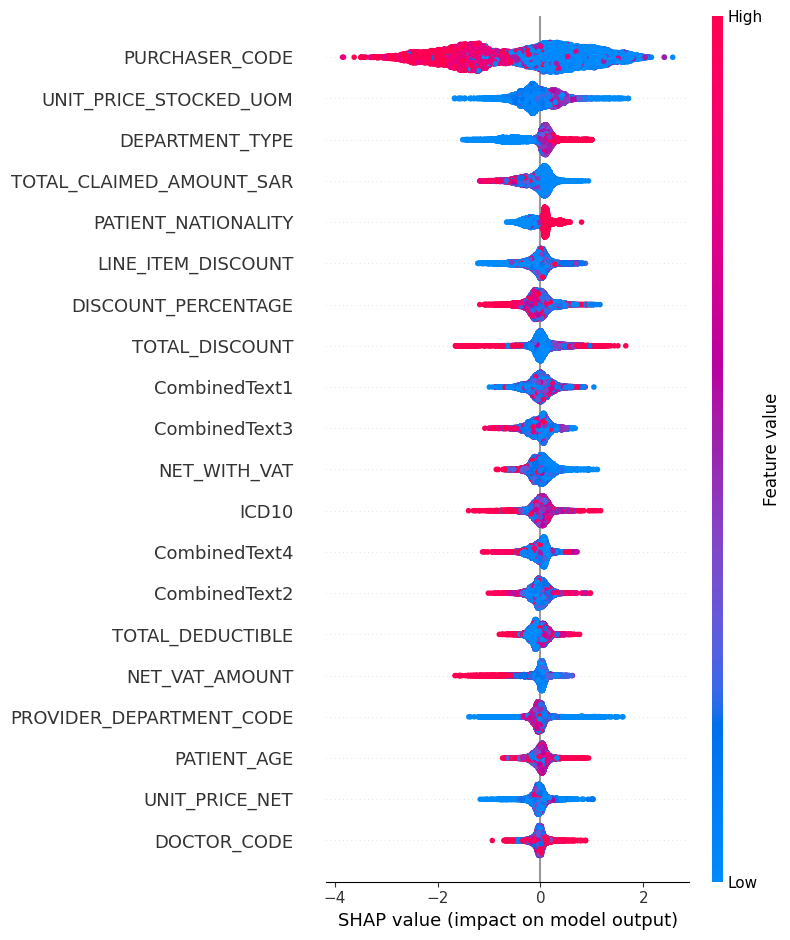

In [41]:
shap.summary_plot(shap_values,X_test_encoded,feature_names=X_test_encoded.columns)

E:\SC\testing\Claims_Rejection\lib\site-packages\shap\explainers\_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


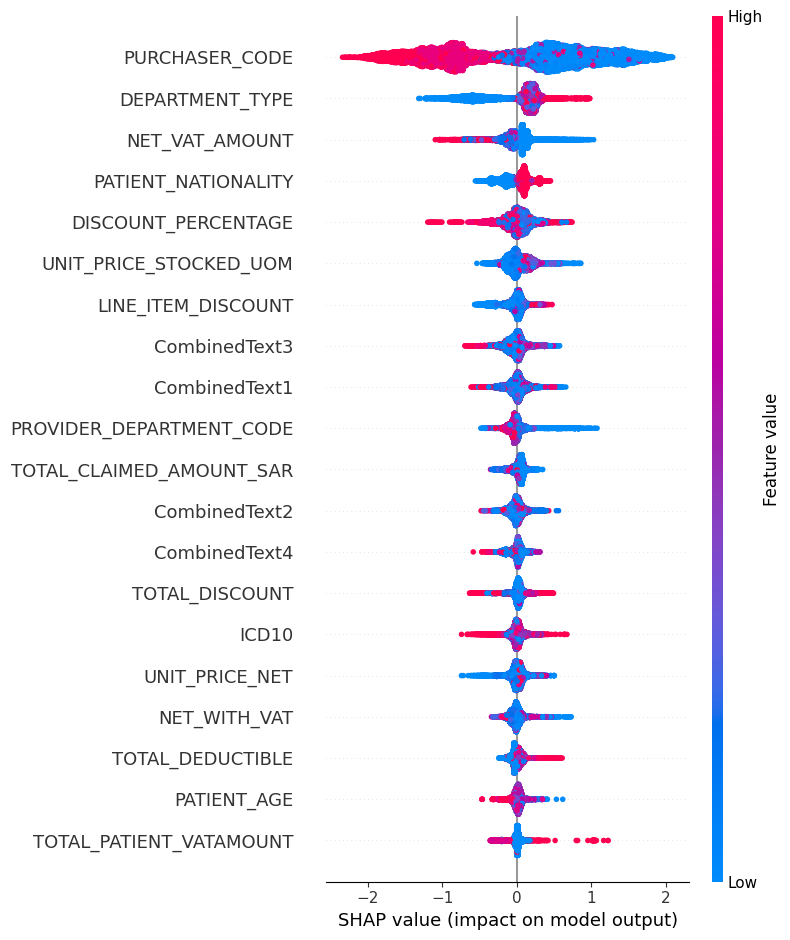

In [42]:
# shap values for lgbm
explainer = shap.TreeExplainer(model_runner.lgbm_model)
shap_values = explainer.shap_values(X_test_encoded)
shap.summary_plot(shap_values,X_test_encoded,feature_names=X_test_encoded.columns)

In [43]:
# shap values for sgd
explainer = shap.TreeExplainer(model_runner.sgd_model)
shap_values = explainer.shap_values(X_test_encoded)
shap.summary_plot(shap_values,X_test_encoded,feature_names=X_test_encoded.columns)

InvalidModelError: Model type not yet supported by TreeExplainer: <class 'sklearn.linear_model._stochastic_gradient.SGDClassifier'>